In [1]:
import os
from PIL import Image
import numpy as np
from skimage import color
import torch
from skimage.color import lab2rgb
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time
from generator import Generator
from BaseColor import *

2025-06-29 09:06:27.400403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-29 09:06:27.400565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-29 09:06:27.510040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-29 09:06:27.729828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-29 09:06:29.691946: W tensorflow/compiler/tf2

In [2]:

def find_images_recursive(folder, extensions=('.JPEG', '.jpeg', '.jpg', '.JPG')):
    img_paths = []
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.endswith(extensions):
                img_paths.append(os.path.abspath(os.path.join(root, f)))
    return img_paths


In [3]:
class ColorizationDataset(Dataset, BaseColor):
    def __init__(self, root_dir, HW=(256, 256), extensions=('.JPEG', '.jpeg', '.jpg', '.JPG')):
        Dataset.__init__(self)
        BaseColor.__init__(self)
        self.HW = HW
        self.img_paths = find_images_recursive(root_dir, extensions)
        print(f"Pronađeno {len(self.img_paths)} slika u {root_dir} i podfolderima.")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]

        try:
            img_rgb_orig = load_img(img_path)

            tens_orig_l, tens_rs_l = preprocess_img(img_rgb_orig, HW=self.HW)

            img_rgb_rs = resize_img(img_rgb_orig, HW=self.HW, resample=Image.BILINEAR)
            img_lab_rs = color.rgb2lab(img_rgb_rs).astype(np.float32)

            img_ab_rs = img_lab_rs[:, :, 1:3]
            tens_ab = torch.tensor(img_ab_rs).permute(2,0,1).float()

            tens_l_norm = self.normalize_l(tens_rs_l.squeeze(0))
            tens_ab_norm = self.normalize_ab(tens_ab)

            return tens_l_norm, tens_ab_norm

        except Exception as e:
            print(f"Preskačem fajl zbog greške: {img_path}\nGreška: {e}")
            return self.__getitem__((idx + 1) % len(self))



In [4]:
dataset = ColorizationDataset("images_pfe1", HW=(256, 256))
input_l, target_ab = dataset[0]

Pronađeno 130000 slika u images_pfe1 i podfolderima.


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
HW = (256, 256) 

In [6]:
device

device(type='cuda')

In [7]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [8]:
model = Generator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
next(model.parameters()).is_cuda

True

In [10]:
def numpy_to_tensor(np_img):
    if isinstance(np_img, np.ndarray):
        tensor = torch.from_numpy(np_img.astype(np.float32))
        if tensor.ndim == 3:
            tensor = tensor.permute(2, 0, 1)
        elif tensor.ndim == 4:
            tensor = tensor.permute(0, 3, 1, 2)
        return tensor
    else:
        raise TypeError("Ulaz nije NumPy niz")


In [11]:
def safe_lab2rgb(lab):
    lab_clipped = lab.copy()
    lab_clipped[..., 0] = np.clip(lab_clipped[..., 0], 0, 100)     
    lab_clipped[..., 1] = np.clip(lab_clipped[..., 1], -110, 110)  
    lab_clipped[..., 2] = np.clip(lab_clipped[..., 2], -110, 110)  

    rgb = lab2rgb(lab_clipped)
    return rgb

In [12]:
def lab_to_rgb_image(input_l, ab):
    base_color = BaseColor()
    l_denorm = base_color.unnormalize_l(input_l)
    ab_denorm = base_color.unnormalize_ab(ab)

    #l_denorm = torch.clamp(l_denorm, 0, 100)
    #ab_denorm = torch.clamp(ab_denorm, -110, 110)

    lab = torch.cat([l_denorm, ab_denorm], dim=1)
    lab_np = lab[0].permute(1, 2, 0).cpu().numpy()

    rgb = lab2rgb(lab_np)
    return rgb

In [13]:
def delta_e_loss(input_l, ab_pred, ab_true):
    base_color = BaseColor()
    l_denorm = base_color.unnormalize_l(input_l)
    ab_pred_denorm = base_color.unnormalize_ab(ab_pred)
    ab_true_denorm = base_color.unnormalize_ab(ab_true)

    lab_pred = torch.cat([l_denorm, ab_pred_denorm], dim=1)
    lab_true = torch.cat([l_denorm, ab_true_denorm], dim=1)

    delta_e = torch.norm(lab_pred - lab_true, dim=1)  
    return delta_e.mean()

def colorfulness_loss(ab_pred):
    return -ab_pred.abs().mean()



In [14]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Ако су тензори (C, H, W), пребаци у (H, W, C) и NumPy
def show_images(real, fake):
    real = real.permute(1, 2, 0).detach().cpu().numpy()
    fake = fake.permute(1, 2, 0).detach().cpu().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(real)
    axs[0].set_title("Originalna slika")
    axs[0].axis('off')

    axs[1].imshow(fake)
    axs[1].set_title("Generisana slika")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


In [18]:

start_epoch = 0
checkpoint_path = 'checkpoint.pth1'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    global_step = checkpoint.get('global_step', 0)
    print(f"Nastavljam od epohe {start_epoch}, global_step = {global_step}")
else:
    global_step = 0

In [58]:

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

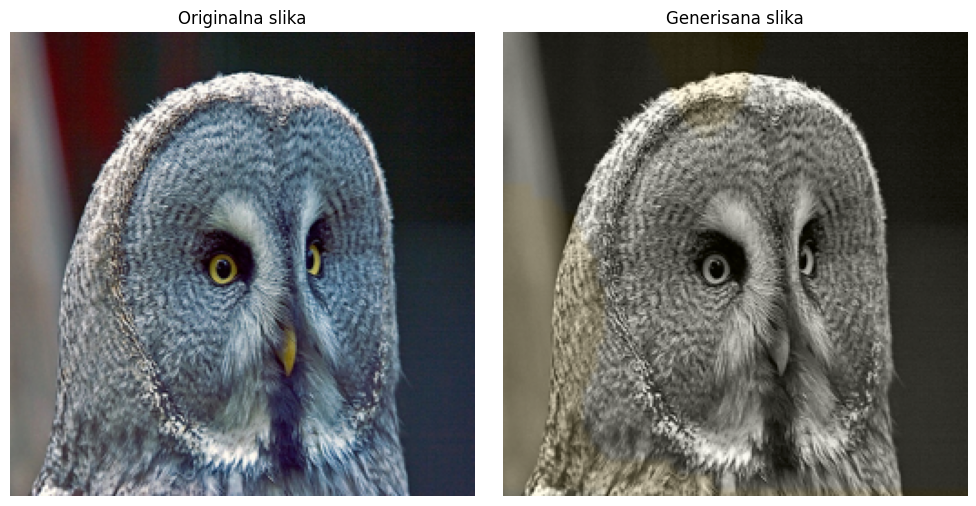

Epoch [1/10], Batch [1/4063], Loss: 18.2108
Epoch [1/10], Batch [101/4063], Loss: 17.9367
Epoch [1/10], Batch [201/4063], Loss: 16.2489
Epoch [1/10], Batch [301/4063], Loss: 18.1360
Epoch [1/10], Batch [401/4063], Loss: 18.0808
Epoch [1/10], Batch [501/4063], Loss: 21.7932
Epoch [1/10], Batch [601/4063], Loss: 16.4680
Epoch [1/10], Batch [701/4063], Loss: 15.0555
Epoch [1/10], Batch [801/4063], Loss: 16.3559
Epoch [1/10], Batch [901/4063], Loss: 20.3223


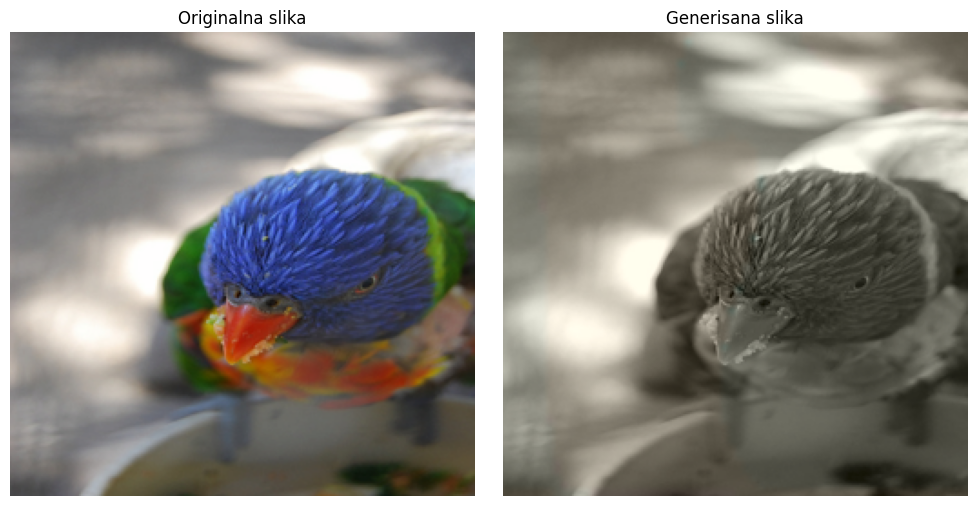

Epoch [1/10], Batch [1001/4063], Loss: 17.3680
Epoch [1/10], Batch [1101/4063], Loss: 16.1309
Preskačem fajl zbog greške: /notebooks/images_pfe1/train.X2/n02077923/n02077923_14822.JPEG
Greška: the input array must have size 3 along `channel_axis`, got (1200, 1600, 4)
Epoch [1/10], Batch [1201/4063], Loss: 19.9525


KeyboardInterrupt: 

In [25]:
import warnings
import matplotlib.pyplot as plt

# warnings.filterwarnings("ignore", message="Conversion from CIE-LAB, via XYZ to sRGB color space resulted in .* negative Z values.*")

epoch_losses = [] 
global_step = 0

for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    for batch_idx, (input_l, target_ab) in enumerate(dataloader):
        input_l = input_l.to(device)        
        target_ab = target_ab.to(device) 
        optimizer.zero_grad()

        output_ab = model(input_l)         

        color_loss = delta_e_loss(input_l, output_ab, target_ab)
        boost_color = colorfulness_loss(output_ab)
        loss = color_loss + 0.1 * boost_color
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if global_step % 100 == 0:
            with torch.no_grad():
                fake_rgb_np = lab_to_rgb_image(input_l, output_ab)
                real_rgb_np = lab_to_rgb_image(input_l, target_ab)

                fake_rgb = numpy_to_tensor(fake_rgb_np).to(device)  
                real_rgb = numpy_to_tensor(real_rgb_np).to(device)

                fake_rgb_vis = fake_rgb.clone().clamp(0, 1)
                real_rgb_vis = real_rgb.clone().clamp(0, 1)

            N = min(4, fake_rgb_vis.size(0))
            if fake_rgb_vis.ndim == 3:  
                fake_rgb_vis = fake_rgb_vis.unsqueeze(0)  
            if real_rgb_vis.ndim == 3:
                real_rgb_vis = real_rgb_vis.unsqueeze(0)
    
            fake_rgb_vis_uint8 = (fake_rgb_vis * 255).clamp(0, 255).to(torch.uint8)
            real_rgb_vis_uint8 = (real_rgb_vis * 255).clamp(0, 255).to(torch.uint8)

            if global_step % 1000 == 0:
                show_images(real_rgb_vis_uint8[0], fake_rgb_vis_uint8[0])

            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

        global_step += 1

    avg_epoch_loss = epoch_loss / len(dataloader)
    epoch_losses.append(avg_epoch_loss) 
    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1} završena. Prosečni loss: {avg_epoch_loss:.4f}. Vreme epohe: {elapsed:.1f} s")
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'global_step': global_step
    }, checkpoint_path)

print("Trening završen.")

plt.figure(figsize=(8, 5))
plt.plot(range(start_epoch + 1, start_epoch + 1 + len(epoch_losses)), epoch_losses, marker='o')
plt.title('Loss tokom epoha')
plt.xlabel('Epoka')
plt.ylabel('Prosečni loss')
plt.grid(True)
plt.show()

